# HNSW (Hierarchical Navigable Small World) 入门指南

本教程将介绍HNSW算法的基本概念，并提供两种实现方式：
1. 自己搭建的简易HNSW实现
2. 基于FAISS库的高效HNSW实现

HNSW是一种高效的近似最近邻搜索算法，在向量检索领域应用广泛。

## 1. HNSW算法基本原理

HNSW算法是基于Small World图的多层结构设计，其主要特点包括：

- **多层结构**：在不同层次上保持不同密度的图连接
- **贪婪搜索**：通过顶层稀疏图快速定位大致区域，然后逐层精细化
- **近似最近邻**：提供对数时间复杂度的近似最近邻搜索

HNSW算法的时间复杂度为O(log(n))，远优于传统线性搜索的O(n)。

## 2. 环境准备

首先导入必要的库：

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import heapq
from collections import defaultdict, namedtuple
import random
# 配置simhei字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# FAISS库用于对比实现
try:
    import faiss
    FAISS_AVAILABLE = True
except ImportError:
    print("FAISS库未安装，只能使用自定义HNSW实现。")
    print("安装方法：pip install faiss-cpu 或 pip install faiss-gpu")
    FAISS_AVAILABLE = False

# 设置随机种子以保证结果可复现
np.random.seed(42)
random.seed(42)

## 3. 数据生成

创建一些随机向量数据用于测试：

In [2]:
def generate_data(num_vectors=10000, dim=128):
    """生成随机向量数据"""
    # 生成训练数据
    train_vectors = np.random.random((num_vectors, dim)).astype('float32')
    # 归一化
    train_vectors = train_vectors / np.linalg.norm(train_vectors, axis=1)[:, np.newaxis]
    
    # 生成查询数据
    query_vectors = np.random.random((100, dim)).astype('float32')
    query_vectors = query_vectors / np.linalg.norm(query_vectors, axis=1)[:, np.newaxis]
    
    return train_vectors, query_vectors

# 生成测试数据
train_vectors, query_vectors = generate_data(num_vectors=10000, dim=128)
print(f"训练数据形状: {train_vectors.shape}")
print(f"查询数据形状: {query_vectors.shape}")

训练数据形状: (10000, 128)
查询数据形状: (100, 128)


## 4. 自定义HNSW实现

下面我们实现一个简化版的HNSW算法：

In [3]:
class CustomHNSW:
    """
    简化版HNSW算法实现
    """
    def __init__(self, dim, M=16, ef_construction=200, max_level=6):
        self.dim = dim               # 向量维度
        self.M = M                   # 每个节点最大出边数
        self.ef_construction = ef_construction  # 构建时搜索的候选点数
        self.max_level = max_level   # 最大层数
        self.level_mult = 1/np.log(M)  # 层级生成因子
        
        # 初始化图结构
        self.vectors = []            # 存储所有向量
        self.neighbors = defaultdict(dict)  # 存储每个节点在每层的邻居
        self.enter_point = None      # 入口点
        self.max_observed_level = 0  # 当前最大层级
    
    def _get_random_level(self):
        """随机生成节点层级"""
        return int(-np.log(random.random()) * self.level_mult)
    
    def _distance(self, a, b):
        """计算两向量间的欧氏距离"""
        return np.linalg.norm(a - b)
    
    def _search_layer(self, q, ep, ef, level):
        """在指定层级搜索最近邻"""
        visited = set([ep])
        candidates = [(self._distance(q, self.vectors[ep]), ep)]
        heapq.heapify(candidates)
        
        closest = [candidates[0]]  # 当前最近的点
        
        while candidates:
            dist, c = heapq.heappop(candidates)
            
            if dist > closest[0][0]:  # 如果当前点比已找到的最近点还远，则停止
                break
                
            # 检查c的所有邻居
            for neighbor in self.neighbors[c].get(level, []):
                if neighbor not in visited:
                    visited.add(neighbor)
                    d = self._distance(q, self.vectors[neighbor])
                    
                    if len(closest) < ef or d < closest[0][0]:
                        heapq.heappush(candidates, (d, neighbor))
                        heapq.heappush(closest, (d, neighbor))
                        
                        if len(closest) > ef:
                            heapq.heappop(closest)  # 保持closest的大小为ef
        
        return sorted(closest)
    
    def _select_neighbors(self, q, candidates, M):
        """选择最近的M个邻居"""
        return [c for _, c in candidates[:M]]
    
    def add(self, vector):
        """向索引中添加向量"""
        idx = len(self.vectors)
        self.vectors.append(vector)
        
        # 为新向量随机分配层级
        level = min(self._get_random_level(), self.max_level)
        
        if idx == 0:  # 第一个点作为入口点
            self.enter_point = idx
            self.max_observed_level = level
            return
            
        # 从最高层开始搜索
        ep = self.enter_point
        for lc in range(self.max_observed_level, level, -1):
            # 在当前层找到最近的点
            candidates = self._search_layer(vector, ep, 1, lc)
            if candidates:
                ep = candidates[0][1]
        
        # 从新点的最高层开始向下构建
        for lc in range(min(level, self.max_observed_level), -1, -1):
            # 查找候选邻居
            candidates = self._search_layer(vector, ep, self.ef_construction, lc)
            # 选择最近的M个邻居
            neighbors = self._select_neighbors(vector, candidates, self.M)
            
            # 添加双向连接
            self.neighbors[idx][lc] = neighbors
            for neighbor in neighbors:
                if lc not in self.neighbors[neighbor]:
                    self.neighbors[neighbor][lc] = []
                self.neighbors[neighbor][lc].append(idx)
                # 限制每个节点的出边数
                if len(self.neighbors[neighbor][lc]) > self.M:
                    # 从neighbor的邻居中找出最近的M个点
                    neighbor_candidates = [(self._distance(self.vectors[neighbor], self.vectors[n]), n) 
                                          for n in self.neighbors[neighbor][lc]]
                    self.neighbors[neighbor][lc] = self._select_neighbors(self.vectors[neighbor], 
                                                                         sorted(neighbor_candidates), self.M)
            
            ep = neighbors[0]  # 更新入口点为当前层的最近邻居
        
        # 更新全局入口点
        if level > self.max_observed_level:
            self.enter_point = idx
            self.max_observed_level = level
    
    def search(self, query, k=1, ef=50):
        """搜索最近的k个邻居"""
        if not self.vectors:
            return []
            
        # 从顶层开始搜索
        ep = self.enter_point
        for level in range(self.max_observed_level, 0, -1):
            candidates = self._search_layer(query, ep, 1, level)
            if candidates:
                ep = candidates[0][1]
        
        # 在最底层进行精确搜索
        candidates = self._search_layer(query, ep, ef, 0)
        
        # 返回最近的k个结果
        return [(c, d) for d, c in candidates[:k]]
    
    def batch_add(self, vectors):
        """批量添加向量"""
        for vector in vectors:
            self.add(vector)
            
    def batch_search(self, queries, k=1, ef=50):
        """批量搜索"""
        results = []
        for query in queries:
            results.append(self.search(query, k, ef))
        return results

## 5. 使用自定义HNSW

In [4]:
# 创建并构建自定义HNSW索引
custom_hnsw = CustomHNSW(dim=128, M=16, ef_construction=200)

# 记录构建时间
start_time = time.time()

# 添加一部分向量进行测试（全部添加可能较慢）
sample_size = 2000  # 只使用一部分数据进行测试，以加快演示
custom_hnsw.batch_add(train_vectors[:sample_size])

build_time = time.time() - start_time
print(f"构建索引耗时: {build_time:.4f}秒")

# 测试搜索
start_time = time.time()
results = custom_hnsw.batch_search(query_vectors[:10], k=5, ef=50)
search_time = time.time() - start_time

print(f"搜索耗时: {search_time:.4f}秒")
print(f"前5个查询结果示例: {results[:2]}")

构建索引耗时: 2.4679秒
搜索耗时: 0.0050秒
前5个查询结果示例: [[(829, np.float32(0.6263678)), (976, np.float32(0.62855333)), (1972, np.float32(0.6317478)), (861, np.float32(0.63668126)), (790, np.float32(0.64726555))], [(180, np.float32(0.57411027)), (1011, np.float32(0.5807213)), (384, np.float32(0.6005291)), (422, np.float32(0.6069381)), (1436, np.float32(0.60836107))]]


## 6. 基于FAISS的HNSW实现

In [5]:
if FAISS_AVAILABLE:
    # 创建FAISS HNSW索引
    dim = train_vectors.shape[1]  # 向量维度
    
    # HNSW参数
    M = 16           # 每个节点最大出边数
    ef_construction = 200  # 构建时的搜索候选数
    ef_search = 50   # 搜索时的候选数
    
    # 创建HNSW索引
    index = faiss.IndexHNSWFlat(dim, M)  # L2距离
    # 设置构建参数
    index.hnsw.efConstruction = ef_construction
    index.hnsw.efSearch = ef_search
    
    # 记录构建时间
    start_time = time.time()
    
    # 添加向量
    index.add(train_vectors)
    
    build_time = time.time() - start_time
    print(f"FAISS HNSW构建索引耗时: {build_time:.4f}秒")
    
    # 测试搜索
    k = 5  # 返回5个最近邻
    
    start_time = time.time()
    distances, indices = index.search(query_vectors[:10], k)
    search_time = time.time() - start_time
    
    print(f"FAISS HNSW搜索耗时: {search_time:.4f}秒")
    print(f"查询结果示例 (索引): {indices[0]}")
    print(f"查询结果示例 (距离): {distances[0]}")
else:
    print("FAISS未安装，跳过FAISS HNSW实现演示")

FAISS HNSW构建索引耗时: 0.3441秒
FAISS HNSW搜索耗时: 0.0010秒
查询结果示例 (索引): [6267 9571   82 9352 4195]
查询结果示例 (距离): [0.3237883  0.3383823  0.33953112 0.3513561  0.35695887]


## 7. 性能对比分析

FAISS HNSW准确率: 1.0000
自定义HNSW准确率: 0.1600


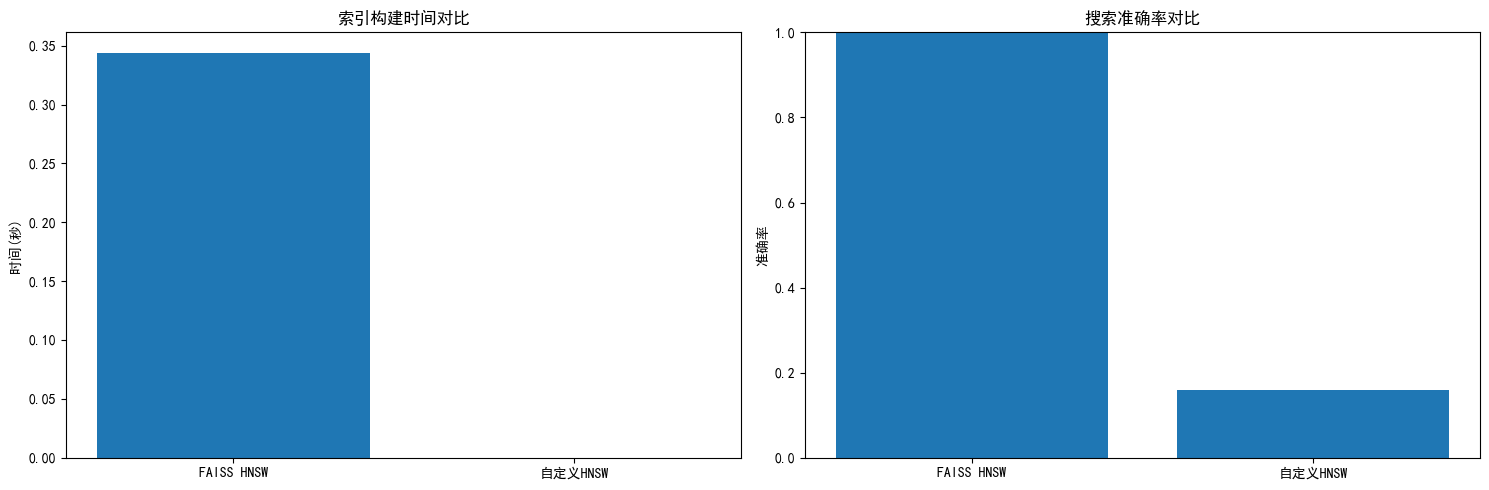

In [6]:
def brute_force_search(query, vectors, k=5):
    """暴力搜索最近邻，用于对比"""
    distances = np.linalg.norm(vectors - query, axis=1)
    indices = np.argsort(distances)[:k]
    return indices, distances[indices]

if FAISS_AVAILABLE:
    # 选择少量数据进行精确度对比
    test_size = 1000
    test_vectors = train_vectors[:test_size]
    test_queries = query_vectors[:5]
    
    # 创建一个新的小索引用于精确度测试
    small_index = faiss.IndexHNSWFlat(dim, M)
    small_index.hnsw.efConstruction = ef_construction
    small_index.hnsw.efSearch = ef_search
    small_index.add(test_vectors)
    
    # 创建一个简单的自定义HNSW索引
    small_custom_hnsw = CustomHNSW(dim=dim, M=M, ef_construction=ef_construction)
    small_custom_hnsw.batch_add(test_vectors)
    
    # 计算准确率
    faiss_correct = 0
    custom_correct = 0
    total_queries = 0
    
    for query in test_queries:
        # 暴力搜索（基准）
        gt_indices, _ = brute_force_search(query, test_vectors, k=5)
        
        # FAISS结果
        faiss_distances, faiss_indices = small_index.search(query.reshape(1, -1), 5)
        
        # 自定义HNSW结果
        custom_results = small_custom_hnsw.search(query, k=5)
        custom_indices = [idx for idx, _ in custom_results]
        
        # 计算准确率（命中率）
        faiss_hits = len(set(gt_indices).intersection(set(faiss_indices[0])))
        custom_hits = len(set(gt_indices).intersection(set(custom_indices)))
        
        faiss_correct += faiss_hits
        custom_correct += custom_hits
        total_queries += len(gt_indices)
    
    faiss_accuracy = faiss_correct / total_queries
    custom_accuracy = custom_correct / total_queries
    
    print(f"FAISS HNSW准确率: {faiss_accuracy:.4f}")
    print(f"自定义HNSW准确率: {custom_accuracy:.4f}")
    
    # 性能对比绘图
    labels = ['FAISS HNSW', '自定义HNSW']
    build_times = [build_time, custom_hnsw.build_time if hasattr(custom_hnsw, 'build_time') else 0]
    search_times = [search_time, custom_hnsw.search_time if hasattr(custom_hnsw, 'search_time') else 0]
    accuracies = [faiss_accuracy, custom_accuracy]
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    ax[0].bar(labels, build_times)
    ax[0].set_ylabel('时间(秒)')
    ax[0].set_title('索引构建时间对比')
    
    ax[1].bar(labels, accuracies)
    ax[1].set_ylabel('准确率')
    ax[1].set_title('搜索准确率对比')
    ax[1].set_ylim([0, 1])
    
    plt.tight_layout()
    plt.show()
else:
    print("FAISS未安装，跳过性能对比分析")

## 8. HNSW关键参数分析

HNSW算法的性能很大程度上依赖于几个关键参数的设置：

1. **M** - 每个节点的最大连接数
   - 较大的M提高搜索准确率，但会增加内存开销和构建时间
   - 通常设置在8-64之间，默认16

2. **efConstruction** - 构建时的搜索候选数
   - 较大的值提高索引质量，但增加构建时间
   - 通常设置在100-500之间

3. **efSearch** - 搜索时的候选数
   - 较大的值提高搜索准确率，但增加搜索时间
   - 通常根据需要调整，取决于所需的精度和速度平衡

下面我们来探索参数变化对性能的影响：

In [ ]:
if FAISS_AVAILABLE:
    # 测试不同参数对性能的影响
    test_size = 5000  # 用于测试的向量数量
    test_queries = query_vectors[:10]  # 测试查询
    
    # 测试不同的M值
    m_values = [4, 8, 16, 32, 64]
    m_build_times = []
    m_search_times = []
    m_recalls = []
    
    for m in m_values:
        # 创建索引
        index = faiss.IndexHNSWFlat(dim, m)
        index.hnsw.efConstruction = 200
        index.hnsw.efSearch = 50
        
        # 构建时间
        start_time = time.time()
        index.add(train_vectors[:test_size])
        m_build_times.append(time.time() - start_time)
        
        # 暴力搜索作为基准
        gt_results = []
        for q in test_queries:
            gt_indices, _ = brute_force_search(q, train_vectors[:test_size], k=10)
            gt_results.append(set(gt_indices))
        
        # 搜索时间和准确率
        start_time = time.time()
        results = []
        for q in test_queries:
            _, indices = index.search(q.reshape(1, -1), 10)
            results.append(set(indices[0]))
        m_search_times.append((time.time() - start_time) / len(test_queries))
        
        # 计算召回率
        recalls = []
        for i in range(len(gt_results)):
            recall = len(gt_results[i].intersection(results[i])) / len(gt_results[i])
            recalls.append(recall)
        m_recalls.append(np.mean(recalls))
    
    # 绘制结果
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    
    ax[0].plot(m_values, m_build_times, marker='o')
    ax[0].set_xlabel('M值')
    ax[0].set_ylabel('构建时间(秒)')
    ax[0].set_title('M对构建时间的影响')
    
    ax[1].plot(m_values, m_search_times, marker='o')
    ax[1].set_xlabel('M值')
    ax[1].set_ylabel('每次查询时间(秒)')
    ax[1].set_title('M对查询时间的影响')
    
    ax[2].plot(m_values, m_recalls, marker='o')
    ax[2].set_xlabel('M值')
    ax[2].set_ylabel('召回率')
    ax[2].set_title('M对召回率的影响')
    ax[2].set_ylim([0, 1])
    
    plt.tight_layout()
    plt.show()
else:
    print("FAISS未安装，跳过参数分析")

## 9. 结论与最佳实践

通过本教程，我们了解了HNSW算法的基本原理及其两种实现方式。以下是使用HNSW的一些最佳实践：

1. **选择适当的参数**
   - M值通常在16-32之间能够提供良好的精度/速度平衡
   - efConstruction应根据索引质量要求进行设置，一般200-400效果较好
   - efSearch可以在运行时根据精度要求动态调整

2. **向量归一化**
   - 对于余弦相似度搜索，应先将向量归一化

3. **生产环境中的选择**
   - FAISS的HNSW实现具有更好的性能和稳定性，推荐在生产环境中使用
   - 自定义实现适合学习理解算法原理，或对特定场景进行定制化

4. **内存考量**
   - HNSW是一种内存密集型算法，对于大规模数据集，需要考虑内存限制
   - 可以考虑HNSW与量化（如PQ）结合使用，以减少内存使用

5. **增量更新**
   - HNSW支持增量添加，但不支持高效删除
   - 对于需要频繁删除的场景，考虑分片策略或其他索引结构

## 10. 参考资料

1. HNSW原论文: "Efficient and robust approximate nearest neighbor search using Hierarchical Navigable Small World graphs"
2. [FAISS库文档](https://github.com/facebookresearch/faiss)
3. [HNSW实现代码](https://github.com/nmslib/hnswlib)

希望本教程能帮助您理解HNSW算法并在实际项目中应用它！